In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_percentage_error
from deap import base, creator, tools, algorithms

In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)   

data = pd.read_csv('DATA_KOTA.csv')

df = pd.DataFrame(data)

# Membagi kolom tanggal menjadi tahun dan bulan
df['tahun'] = df['tahun_bulan'].apply(lambda x: int(x.split('-')[0]))
df['bulan'] = df['tahun_bulan'].apply(lambda x: int(x.split('-')[1]))

# Normalisasi MinMax
scaler = MinMaxScaler()
df['jumlah_kecelakaan'] = scaler.fit_transform(df[['jumlah_kecelakaan']])

# Memisahkan fitur dan target
X = df[['tahun', 'bulan']].values
y = df['jumlah_kecelakaan'].values

In [3]:
# Pisahkan data menjadi training dan testing
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [4]:
# Definisikan evaluasi fungsi
def evaluate(individual):
    epsilon = individual[0]
    if epsilon <= 0:
        return float('inf'),
    svr = SVR(kernel='linear', epsilon=epsilon, C=1, gamma=0.1)  # Gunakan nilai tetap untuk C dan gamma
    svr.fit(X_train, y_train)
    predictions = svr.predict(X_val)
    mape = mean_absolute_percentage_error(y_val, predictions) * 100
    return mape,

# Inisialisasi populasi awal
def initialize_population(population_size, parameter_ranges):
    population = []
    for _ in range(population_size):
        chromosome = []
        for param_range in parameter_ranges:
            param_value = np.random.uniform(param_range[0], param_range[1])
            chromosome.append(param_value)
        population.append(chromosome)
    return population

# Seleksi individu berdasarkan nilai fitness (MAPE)
def selection(population):
    fitnesses = list(map(evaluate, population))
    selected_population = [ind for ind, fit in sorted(zip(population, fitnesses), key=lambda ind_fit: ind_fit[1])]
    return selected_population[:len(population)//2]

# Crossover: Menghasilkan keturunan dari pasangan individu terpilih
def crossover(selected_population):
    new_population = []
    ukuran_populasi = len(selected_population)
    
    for i in range(ukuran_populasi):
        parent1 = selected_population[i]
        
        # Tentukan parent2 dengan pemeriksaan batas
        if i % 2 == 0:
            if i - 1 >= 0:
                parent2 = selected_population[i-1]
            else:
                parent2 = selected_population[i]
        else:
            if i + 1 < ukuran_populasi:
                parent2 = selected_population[i+1]
            else:
                parent2 = selected_population[i]
        
        if len(parent1) > 2:
            crossover_point = np.random.randint(1, len(parent1)-1)
            child = parent1[:crossover_point] + parent2[crossover_point:]
        else:
            child = parent1  # Jika panjang parent1 tidak memungkinkan, gunakan parent1 tanpa crossover
        
        new_population.append(child)
    
    return new_population

# Mutasi: Mengubah nilai gen secara acak pada populasi baru
def mutation(new_population, mutation_rate, parameter_ranges, sigma_range):
    for i in range(len(new_population)):
        if np.random.random() < mutation_rate:
            mutated_gene_index = np.random.randint(0, len(new_population[i]))
            sigma = np.random.uniform(sigma_range[0], sigma_range[1])
            new_value = new_population[i][mutated_gene_index] + np.random.normal(0, sigma)
            new_population[i][mutated_gene_index] = np.clip(new_value, parameter_ranges[mutated_gene_index][0], parameter_ranges[mutated_gene_index][1])
    return new_population

In [6]:
# Rentang nilai epsilon yang akan diuji
epsilon_ranges = [(0.0000001, 0.0001), (0.0000001, 0.001), (0.0000001, 0.01), (0.00001, 0.0001), (0.00001, 0.001), (0.00001, 0.01), (0.001, 0.1), (0.001, 1), (0.001, 5)]
crossover_rate = 0.3  # Tetapkan tingkat crossover tetap untuk eksperimen
mutation_rate = 0.7  # Tetapkan tingkat mutasi tetap untuk eksperimen
num_generations = 25  # Tetapkan jumlah generasi tetap untuk eksperimen
sigma_range = (0.5, 5)

results = []

# Evaluasi kombinasi epsilon yang diminta
for epsilon_range in epsilon_ranges:
    parameter_ranges = [epsilon_range]
    population_size = 50  # Ukuran populasi tetap

    population = initialize_population(population_size, parameter_ranges)

    for generation in range(num_generations):
        selected_population = selection(population)
        new_population = crossover(selected_population)
        new_population = mutation(new_population, mutation_rate, parameter_ranges, sigma_range)

        # Pastikan ukuran populasi tetap
        if len(new_population) < population_size:
            additional_individuals = initialize_population(population_size - len(new_population), parameter_ranges)
            new_population.extend(additional_individuals)
        elif len(new_population) > population_size:
            new_population = new_population[:population_size]

        assert len(new_population) == population_size, "Ukuran populasi baru tidak sesuai"

        population = new_population

    # Ambil individu terbaik (dengan MAPE terendah) dari populasi terakhir
    best_chromosome = min(population, key=lambda ind: evaluate(ind)[0])
    best_population_mape = evaluate(best_chromosome)[0]
    results.append((epsilon_range, best_population_mape))

    print(f"MAPE terbaik untuk rentang epsilon {epsilon_range}: {best_population_mape}")

# Tampilkan hasil terbaik
best_result = min(results, key=lambda x: x[1])
print(f"\nKombinasi epsilon terbaik:")
print(f"Rentang epsilon: {best_result[0]}")
print(f"MAPE terbaik: {best_result[1]}")

MAPE terbaik untuk rentang epsilon (1e-07, 0.0001): 28.895194799759334
MAPE terbaik untuk rentang epsilon (1e-07, 0.001): 28.900420382692044
MAPE terbaik untuk rentang epsilon (1e-07, 0.01): 28.45824568654014
MAPE terbaik untuk rentang epsilon (1e-05, 0.0001): 28.895673854051868
MAPE terbaik untuk rentang epsilon (1e-05, 0.001): 28.899193179027844
MAPE terbaik untuk rentang epsilon (1e-05, 0.01): 28.45824568654014
MAPE terbaik untuk rentang epsilon (0.001, 0.1): 24.706920752243438
MAPE terbaik untuk rentang epsilon (0.001, 1): 25.437075969109518
MAPE terbaik untuk rentang epsilon (0.001, 5): 27.602581890094246

Kombinasi epsilon terbaik:
Rentang epsilon: (0.001, 0.1)
MAPE terbaik: 24.706920752243438


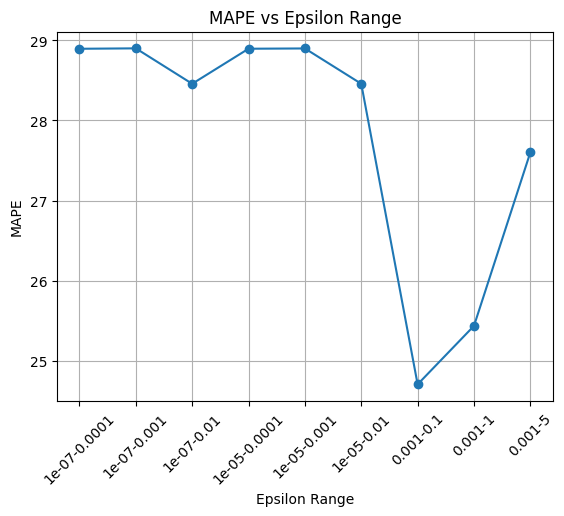

In [7]:
# Plot hasil
fig, ax = plt.subplots()
epsilon_ranges_str = [f"{r[0]}-{r[1]}" for r in epsilon_ranges]
mapes = [r[1] for r in results]
ax.plot(epsilon_ranges_str, mapes, marker='o')
ax.set_xlabel('Epsilon Range')
ax.set_ylabel('MAPE')
ax.set_title('MAPE vs Epsilon Range')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()